In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/ProbAI/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/ProbAI


In [11]:
import pandas as pd
import torch
import tensorflow as tf
import tensorflow_probability as tfp
from typing import List



data_moons = pd.read_csv('/content/drive/MyDrive/ProbAI/datasets/two_moons.csv')
two_blobs = pd.read_csv('/content/drive/MyDrive/ProbAI/datasets/two_blobs.csv')
boomerang = pd.read_csv('/content/drive/MyDrive/ProbAI/datasets/boomerang.csv')

#print(data_moons)

In [5]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras import Model
import numpy as np

N = 500
variational_mean = tf.Variable(tf.zeros((N,2)))
variational_log_scale = tf.Variable(tf.zeros((N,2)))
variational_density = tfp.distributions.MultivariateNormalDiag(
    loc=variational_mean,
    scale_diag=tfp.util.DeferredTensor(variational_log_scale, tf.math.exp),
)
samples = variational_density.sample()
 # resample x_target with more data points
n_epochs = 10
batch_size = 10
x_target = boomerang

In [6]:


import tensorflow as tf
import tensorflow.keras.layers as layers

class FlowLayer(layers.Layer):
    def __init__(self, flow=None, min_beta=0.01, max_beta=1.0):
        super().__init__()
        self.flow = flow
        self.min_beta = tf.constant(min_beta)
        self.max_beta = tf.constant(max_beta)
        self.beta = tf.Variable(min_beta, dtype=tf.float32, trainable=False)

    def call(self, inputs):
        """
        Requires three parameters: z_mu, z_sigma, params
        Returns reparameterized z_0, transformed z_k, summed log det jacobian, and KL divergence
        """
        if self.flow is not None:
            z_mu, z_log_var, params = inputs
        else:
            z_mu, z_log_var = inputs
        # reparameterize z_mu, z_log_var
        z_var = tf.exp(z_log_var)
        z_0 = self.reparameterize(z_mu, z_var)
        # reshape and extract parameter tensors
        if self.flow is not None:
            params = tf.reshape(params, (-1, self.flow.num_steps, params.shape[-1] // self.flow.num_steps))
            print(params.shape)
            args = [params[:,i,:] for i in range(self.flow.num_steps)]
        # compute forward flow
        zs, ldj = self.flow.forward(z_0, *args, return_sequence=True) if self.flow is not None else ([z_0], tf.constant(0.))
        z_k = zs[-1]
        # compute KL divergence loss
        log_qz0 = tf.reduce_sum(-0.5*(z_log_var + (z_0 - z_mu)**2 / z_var), axis=1)
        log_pzk = tf.reduce_sum(-0.5*z_k**2, axis=1)
        kld = tf.reduce_mean(log_qz0 - log_pzk - ldj)
        self.add_loss(self.beta*kld)
        return zs, ldj, kld

    def reparameterize(self, mu, var):
        eps = tf.random.normal(shape=tf.shape(mu))
        sigma = tf.sqrt(var)
        return mu + sigma*eps

    def set_beta(self, value):
        self.beta.assign(tf.maximum(tf.minimum(value, self.max_beta), self.min_beta))

In [8]:
class Transform(tf.Module):
    def __init__(self,
                 input_shape: tf.TensorShape=None,
                 requires_init=False,
                 has_constant_ldj=False,
                 *args, **kwargs):
        self.input_shape = input_shape
        self.requires_init = requires_init
        self.has_constant_ldj = has_constant_ldj
        name = kwargs['name'] if 'name' in kwargs else type(self).__name__
        super().__init__(name=name)
        if input_shape is not None:
            self.initialize(input_shape)

    def __call__(self, z, *args, **kwargs):
        return self.forward(z, *args, **kwargs)

    def _initialize(self, input_shape):
        """
        Optional subclass implementation for variable initialization.
        """
        pass

    def _forward(self, z, *args, **kwargs):
        """
        Subclass implementation of forward transform z' = f(z)
        """
        raise NotImplementedError('missing implementation of _forward')

    def _inverse(self, z, *args, **kwargs):
        """
        Subclass implementation of inverse transform z = f^-1(z')
        """
        raise NotImplementedError('missing implementation of _inverse')

    def _forward_shape(self, shape: tf.TensorShape):
        """
        Permutes shape according to the forward transform.
        """
        return shape

    def _inverse_shape(self, shape: tf.TensorShape):
        """
        Permutes shape according to the inverse transform.
        """
        return shape


    def forward(self, z, *args, **kwargs):
        """
        Computes the forward transform z' = f(z)
        Returns z', fldj (forward log det Jacobian)
        """
        assert not self.requires_init or self.input_shape is not None, 'not initialized'
        return self._forward(z, *args, **kwargs)

    def inverse(self, z, *args, **kwargs):
        """
        Computes the inverse transform z = f^-1(z')
        Returns z', ildj (inverse log det Jacobian)
        """
        assert not self.requires_init or self.input_shape is not None, 'not initialized'
        return self._inverse(z, *args, **kwargs)


    def initialize(self, input_shape: tf.TensorShape):
        """
        Initializes variables and constants for this transform.
        This step may not be required for all implementations.
        """
        assert input_shape is not None, 'input shape must be provided'
        input_shape = tf.TensorShape(input_shape)
        self.input_shape = input_shape
        self._initialize(input_shape)

    def is_initialized(self):
        return self.input_shape is not None

In [9]:
class AmortizedTransform(Transform):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def _param_count(self, shape: tf.TensorShape):
        """
        Optional subclass implementation of param_count
        """
        return 0

    def _create_variables(self, shape: tf.TensorShape, initializer=None, **var_kwargs):
        """
        Optional subclass implementation of create_variables
        """
        if initializer is None:
            initializer = lambda shape: tf.random.uniform(shape)
        return [tf.Variable(initializer((1,self.param_count(shape))), **var_kwargs)]

    def param_count(self, shape: tf.TensorShape):
        """
        Number of parameters for this transform, given input shape
        """
        count = self._param_count(shape)
        return count.numpy() if isinstance(count, tf.Tensor) else count

    def create_variables(self, shape: tf.TensorShape, initializer=None, **var_kwargs):
        """
        Convenience function for initializing variables that may be used for this amortized transform,
        i.e. creates one or more variables with a total of param_count values. Note that this is not
        generally necessary, but may be useful for some applications.
        """
        return self._create_variables(shape, **var_kwargs)

In [15]:
class Planar(AmortizedTransform):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # define nonlinearity function
        self.h = lambda x: tf.math.tanh(x)
        self.dh = lambda x: 1.0 - tf.square(tf.tanh(x))

    def _alpha(self, u, w):
        wu = tf.matmul(w, u)
        m = -1 + tf.nn.softplus(wu)
        return m - wu

    def _u_hat(self, u, w):
        alpha = self._alpha(u, w)
        alpha_w = alpha*w / tf.reduce_sum(w**2.0)
        return u + tf.transpose(alpha_w, (0,2,1))

    def _wzb(self, w, z, b):
        wz = tf.matmul(w, z) # (b, 1, 1)
        return wz + b

    def _forward(self, z, args: tf.Tensor):
        """
        Computes the forward pass of the transformation: z' = z + uh(wz + b)
        Tensor shapes
        z    : (batch_size, d)
        args : (batch_size, 2*d + 1)
        """
        # set up parameters
        d = tf.shape(z)[1]
        u, w, b = args[:,:d], args[:,d:-1], args[:,-1]
        u = tf.reshape(u, (-1, d, 1))
        w = tf.reshape(w, (-1, 1, d))
        b = tf.reshape(b, (-1, 1, 1))
        z = tf.expand_dims(z, axis=-1)
        # compute forward pass z_k -> z_k+1
        wzb = self._wzb(w, z, b) # (batch_size, 1)
        u_hat = self._u_hat(u, w)
        z_ = z + tf.multiply(u_hat, self.h(wzb))
        # compute log det jacobian
        dh_dz = tf.multiply(self.dh(wzb), w) # (batch_size, 1, d)
        ldj = tf.math.log(tf.math.abs(1.0 + tf.matmul(dh_dz, u_hat)))
        return tf.squeeze(z_, axis=-1), ldj

    def _param_count(self, shape):
        d = shape[-1]
        return 2*d + 1

In [16]:
class Flow(AmortizedTransform):
    def __init__(self, steps: List[Transform], input_shape=None, name='flow', *args, **kwargs):
        """
        Constructs a new flow as a sequence of transforms or sub-flows.
        """
        # unroll nested flows
        steps_acc = []
        for step_i in steps:
            if isinstance(step_i, Flow):
                for step_j in step_i.steps:
                    steps_acc.append(step_j)
            else:
                steps_acc.append(step_i)
        self.steps = steps_acc
        self.num_steps = len(self.steps)
        # add num_flows alias for legacy code
        self.num_flows = self.num_steps
        super().__init__(*args, input_shape=input_shape, name=name, **kwargs)

    @staticmethod
    def uniform(num_flows, transform_init):
        """
        Creates a simple, uniform flow with 'num_flows' steps using the transform_init constructor function.
        transform_init should follow the signature f: i -> Transform, where i is the index of the current step
        in the flow sequence and Transform is a valid transformer instance.
        """
        assert num_flows > 0, "num_flows must be > 0"
        transforms = [transform_init(i) for i in range(num_flows)]
        transform_type = type(transforms[0])
        assert all([transform_type == type(t) for t in transforms]), "All transforms should have the same type for uniform flow"
        return Flow(transforms)

    def _forward_shape(self, input_shape):
        for step in self.steps:
            input_shape = step._forward_shape(input_shape)
        return input_shape

    def _inverse_shape(self, input_shape):
        for step in reversed(self.steps):
            input_shape = step._inverse_shape(input_shape)
        return input_shape

    def _initialize(self, input_shape):
        for step in self.steps:
            step.initialize(input_shape)
            input_shape = step._forward_shape(input_shape)

    def _forward(self, z_0, *params: tf.Tensor, return_sequence=False, **kwargs):
        """
        Computes the forward pass of the flow: z_k = f_k . f_k-1 ... f_1(z)
        Tensor shapes:
        z_0    : (batch_size, d)
        params : optional sequence of tensors (batch_size, m_i) where m_i is the number of parameters for flow step i
        """
        zs = [z_0]
        ldj = 0.0
        for i in range(self.num_steps):
            step = self.steps[i]
            params_i = [params[i]] if len(params) > i else []
            z_i, ldj_i = step.forward(zs[-1], *params_i, **kwargs)
            zs.append(z_i)
            ldj += ldj_i
        return (zs, ldj) if return_sequence else (zs[-1], ldj)

    def _inverse(self, z, *params: tf.Tensor, return_sequence=False, **kwargs):
        """
        Computes the inverse pass of the flow: z_0 = f^-1_1 . f^-1_2 ... f^-1_k(z)
        Tensor shapes:
        z_0    : (batch_size, d)
        params : optional sequence of tensors (batch_size, m_i) where m_i is the number of parameters for flow step i
        """
        zs = [z]
        ldj = 0.0
        for i in range(self.num_steps):
            step = self.steps[self.num_steps-i-1]
            params_i = [params[i]] if len(params) > i else []
            z_i, ldj_i = step.inverse(zs[-1], *params_i, **kwargs)
            tf.debugging.assert_all_finite(z_i, f'{step.name} output nan/inf values for input {zs[-1]}')
            zs.append(z_i)
            ldj += ldj_i
        return (zs, ldj) if return_sequence else (zs[-1], ldj)



    def _param_count(self, shape):
        return tf.math.reduce_sum([t.param_count(shape) for t in self.steps if isinstance(t, AmortizedTransform)])

    def _create_variables(self, shape, initializer=None, **kwargs):
        return sum([t.create_variables(shape, initializer, **kwargs) \
                    for t in self.steps if isinstance(t, AmortizedTransform)],[])

In [17]:
x_target=boomerang

# construct planar flow
num_steps = 7
flow = Flow.uniform(num_steps, lambda i: Planar())
# create trainable parameters;
# planar flow requires parameters to be given on the forward pass
flow_params = flow.create_variables(x_target.shape)

In [18]:
input_0 = Input(shape=(2,))
h = Dense(32, activation='relu')(input_0)
h = Dense(16, activation='relu')(h)
mu = Dense(2)(h)
log_var = Dense(2)(h)
flow_params = Dense(flow.param_count((2,)))(h)
# we give FlowLayer our mu, log variance, and the amortized flow parameters;
# KLD loss will be added automatically
flow_layer = FlowLayer(flow, min_beta=1.0E-3)
zs,_,_ = flow_layer([mu, log_var, flow_params])
model = Model(inputs=input_0, outputs=zs[-1])
model.compile(loss='mse', optimizer='adam', metrics=['mse'])

(None, 7, 5)


In [19]:
# use callback for annealing KLD weight (beta);
betas = np.linspace(1.0E-3, 1.0, n_epochs*N//batch_size)
def update_beta(batch, logs):
    flow_layer.set_beta(betas[batch])
callback = LambdaCallback(on_batch_end=update_beta)

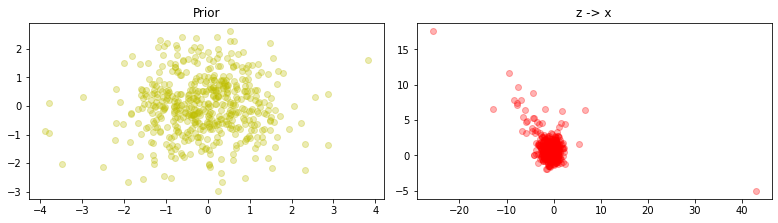

In [21]:
import matplotlib.pyplot as plt

x_pred = model.predict(x_target)
plt.figure(figsize=plt.figaspect(0.2))

 
plt.subplot(1, 3, 1)
#plt.xlim((-1.2, 1.2))
#plt.ylim((-1.5, 1.5))
plt.scatter(x_target[:,0],x_target[:,1],color='Blue',alpha=0.3)
plt.title('data (target)')


plt.subplot(1, 3, 3)
#plt.xlim((-10, 45))
#plt.ylim((-15, 15))
plt.scatter(x_pred[:,0], x_pred[:,1],color='red',alpha=0.3)
plt.title('z -> x')


plt.subplot(1, 3, 2)
#plt.xlim((-10, 45))
#plt.ylim((-15, 15))
plt.scatter(samples[:,0], samples[:,1],color='y',alpha=0.3)
plt.title('Prior')
 
plt.tight_layout()
plt.show()

In [ ]:
# use callback for annealing KLD weight (beta);
x_target=data_moons
betas = np.linspace(1.0E-3, 1.0, n_epochs*N//batch_size)
def update_beta(batch, logs):
    flow_layer.set_beta(betas[batch])
callback = LambdaCallback(on_batch_end=update_beta)
model.fit(x_target, x_target, batch_size=batch_size, epochs=n_epochs, callbacks=[callback])

Epoch 1/10
50/50 [==============================] - 0s 2ms/step - loss: 0.3889 - mse: 0.3321
Epoch 2/10
50/50 [==============================] - 0s 2ms/step - loss: 0.3539 - mse: 0.2951
Epoch 3/10
50/50 [==============================] - 0s 2ms/step - loss: 0.3128 - mse: 0.2487
Epoch 4/10
50/50 [==============================] - 0s 2ms/step - loss: 0.2669 - mse: 0.1940
Epoch 5/10
50/50 [==============================] - 0s 2ms/step - loss: 0.2304 - mse: 0.1389
Epoch 6/10
50/50 [==============================] - 0s 2ms/step - loss: 0.2171 - mse: 0.1108
Epoch 7/10
50/50 [==============================] - 0s 2ms/step - loss: 0.2037 - mse: 0.0920
Epoch 8/10
50/50 [==============================] - 0s 2ms/step - loss: 0.1965 - mse: 0.0741
Epoch 9/10
50/50 [==============================] - 0s 2ms/step - loss: 0.1920 - mse: 0.0716
Epoch 10/10
50/50 [==============================] - 0s 2ms/step - loss: 0.1912 - mse: 0.0642


#Second dataset:Two moons

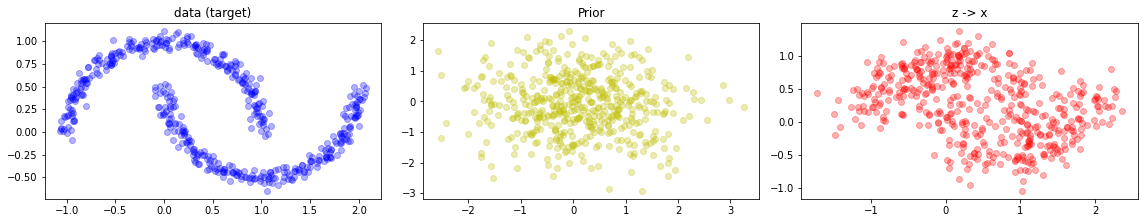

In [ ]:
x_pred = model.predict(x_target)
plt.figure(figsize=plt.figaspect(0.2))

 
plt.subplot(1, 3, 1)
#plt.xlim((-1.2, 1.2))
#plt.ylim((-1.5, 1.5))
plt.scatter(x_target[:,0],x_target[:,1],color='Blue',alpha=0.3)
plt.title('data (target)')


plt.subplot(1, 3, 3)
#plt.xlim((-10, 45))
#plt.ylim((-15, 15))
plt.scatter(x_pred[:,0], x_pred[:,1],color='red',alpha=0.3)
plt.title('z -> x')


plt.subplot(1, 3, 2)
#plt.xlim((-10, 45))
#plt.ylim((-15, 15))
plt.scatter(samples[:,0], samples[:,1],color='y',alpha=0.3)
plt.title('Prior')
 
plt.tight_layout()
plt.show()

#Third dataset:Two blobs

In [ ]:
# use callback for annealing KLD weight (beta);
x_target=two_blobs
betas = np.linspace(1.0E-3, 1.0, n_epochs*N//batch_size)
def update_beta(batch, logs):
    flow_layer.set_beta(betas[batch])
callback = LambdaCallback(on_batch_end=update_beta)
model.fit(x_target, x_target, batch_size=batch_size, epochs=n_epochs, callbacks=[callback])

Epoch 1/10
50/50 [==============================] - 0s 2ms/step - loss: 0.1755 - mse: 0.0676
Epoch 2/10
50/50 [==============================] - 0s 2ms/step - loss: 0.1686 - mse: 0.0626
Epoch 3/10
50/50 [==============================] - 0s 2ms/step - loss: 0.1729 - mse: 0.0564
Epoch 4/10
50/50 [==============================] - 0s 2ms/step - loss: 0.1711 - mse: 0.0551
Epoch 5/10
50/50 [==============================] - 0s 2ms/step - loss: 0.1690 - mse: 0.0544
Epoch 6/10
50/50 [==============================] - 0s 2ms/step - loss: 0.1685 - mse: 0.0503
Epoch 7/10
50/50 [==============================] - 0s 2ms/step - loss: 0.1667 - mse: 0.0501
Epoch 8/10
50/50 [==============================] - 0s 2ms/step - loss: 0.1701 - mse: 0.0504
Epoch 9/10
50/50 [==============================] - 0s 2ms/step - loss: 0.1668 - mse: 0.0499
Epoch 10/10
50/50 [==============================] - 0s 2ms/step - loss: 0.1686 - mse: 0.0575


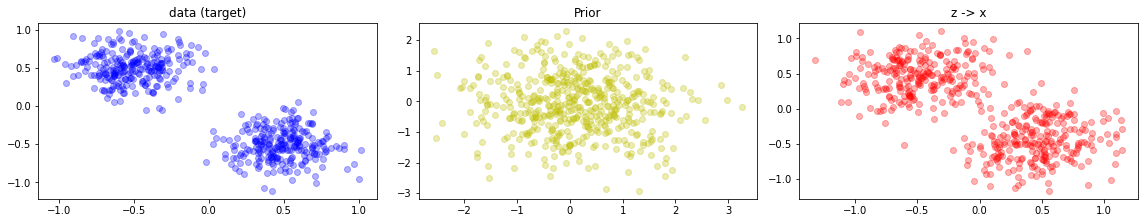

In [ ]:
x_pred = model.predict(x_target)
plt.figure(figsize=plt.figaspect(0.2))

 
plt.subplot(1, 3, 1)
#plt.xlim((-1.2, 1.2))
#plt.ylim((-1.5, 1.5))
plt.scatter(x_target[:,0],x_target[:,1],color='Blue',alpha=0.3)
plt.title('data (target)')


plt.subplot(1, 3, 3)
#plt.xlim((-10, 45))
#plt.ylim((-15, 15))
plt.scatter(x_pred[:,0], x_pred[:,1],color='red',alpha=0.3)
plt.title('z -> x')


plt.subplot(1, 3, 2)
#plt.xlim((-10, 45))
#plt.ylim((-15, 15))
plt.scatter(samples[:,0], samples[:,1],color='y',alpha=0.3)
plt.title('Prior')
 
plt.tight_layout()
plt.show()